# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

Member: 

Tharnarch Thoranisttakul 63340500025 

Sorapas Weerakul 63340500064

Athimet Aiewcharoen 63340500068

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [1]:
import os    
import numpy as np
import numpy.random
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

from resources.embeddings.emb_reader import get_embeddings
from IPython.display import display
from resources.data.orchid_corpus import get_sentences
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from keras.optimizers import Adam
from keras import backend as K
from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss                                                             
from modelConfig import POSConfig
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [2]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


In [3]:
yunk_emb

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818])

Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [4]:
import pickle
fp = open('resources/basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

In [5]:
embeddings

{'พุทธเจ้าพระองค์': array([-0.01917224, -0.00415204, -0.02412283, -0.04142096,  0.04691369,
         0.03376952, -0.00270034, -0.04676848,  0.03299177,  0.03790374,
         0.0432213 , -0.01537431, -0.02517369, -0.04052844, -0.01157572,
         0.00185845, -0.00034374,  0.03099574, -0.00553056,  0.03075998,
        -0.02743803, -0.03812069, -0.02771009, -0.00890391, -0.03464903,
        -0.03346384, -0.04095409,  0.03574741,  0.04473687,  0.0170097 ,
        -0.00490531,  0.01063981], dtype=float32),
 'จุ๊บุ': array([ 0.02896592,  0.02110482,  0.03715003,  0.02296479, -0.03441135,
         0.03496312,  0.03625641, -0.02355627, -0.03617386,  0.01206947,
         0.02429886, -0.02565069, -0.02642049, -0.03778682, -0.00951525,
        -0.0446926 , -0.02631601,  0.04875654,  0.04526813,  0.0079442 ,
         0.0340622 ,  0.00625456,  0.01675535,  0.01817935, -0.03839616,
        -0.04811118,  0.03423071,  0.015117  ,  0.00746933,  0.02313724,
         0.01740095,  0.02209598], dtype=floa

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [6]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

In [7]:
n_classes

48

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [8]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return np.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [9]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [10]:
# %%time
# x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
# y_train = [sent2labels(sent) for sent in train_data]
# x_test = [sent2features(sent, embeddings) for sent in test_data]
# y_test = [sent2labels(sent) for sent in test_data]

# We encounter an error in x_train so we modified it to this following code.

x_train =  [sent2features(sent, embeddings) for sent in train_data]
y_train =  [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test =  [sent2labels(sent) for sent in test_data]

In [11]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train_pad=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_test_pad=tf.keras.preprocessing.sequence.pad_sequences(y_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train_pad)):
    y_temp.append(np.eye(n_classes)[y_train_pad[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [12]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


In [13]:
print(x_test[100],x_test.shape)
print(y_test[100])

[1324  430  324    5  325    5 1327    5 1328    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0] (4625, 102)
[11 11 10  4 10  4 10  4 10]


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [14]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [15]:
def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)
    return df

## 4. Train a model

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

In [16]:
def model_train(x_train,y_train,model,config,retrain=False):

    sub_path = config.log_path + '/'+ model.name
    model_path = sub_path + '/'+ model.name
    log_dir = sub_path + '/Graph/ff'

    callbacks_list = [   
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            model_path,
            save_best_only=True,
            save_weights_only=True,
            monitor=config.monitor,
            mode='min',
            verbose=1
        )]
    
    x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
    if os.path.exists(model_path) and retrain:
        print(f'Model({model.name}) already exists. Loading model from file')
        print('Proceeding to retrain model')
        his = model.fit(x,y=y, batch_size=config.batch_size,epochs=config.epochs,verbose=1,callbacks=callbacks_list,validation_data=(x_val,y_val))
    elif os.path.exists(model_path) and not retrain:
        print(f'Model({model.name}) already exists. Loading model from file')
        return None
    else:
        print(f'Model({model.name}) does not exist. Training new model')
        his = model.fit(x,y=y, batch_size=config.batch_size,epochs=config.epochs,verbose=1,callbacks=callbacks_list,validation_data=(x_val,y_val))
        print('Model trained')

    model.save(model_path)
    return his

## Prediction Function

To get y_pred from the model.

In [17]:
def get_y_pred(model,x_test):
    y_temp = model.predict(x_test)
    y_pred = []
    for data in y_temp:
        temp = np.array([])
        for tag in data:
            if tag == 0:
                break
            temp = np.append(temp,tag)
        y_pred.append(temp)
    return y_pred

### **TensorBoard Observation**

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir='tf_logs/POS/'

## 4.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [19]:
print(f'x_train shape: {x_train.shape} and y_train shape: {y_train_pad.shape}')
print(f'x_test shape: {x_test.shape} and y_test shape: {y_test_pad.shape}')
print(f'Number of classes: {n_classes}')
print(f'Number of words: {len(word_to_idx)}')
print(f'Example of x_train: {x_train[0]}')
print(f'Example of y_train: {y_train_pad[0]}')
print(f'Example of x_test: {x_test[0]}')
print(f'Example of y_test: {y_test_pad[0]}')

x_train shape: (18500, 102) and y_train shape: (18500, 102)
x_test shape: (4625, 102) and y_test shape: (4625, 102)
Number of classes: 48
Number of words: 15019
Example of x_train: [1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Example of y_train: [1 2 3 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Example of x_test: [ 540  454    1  406 3462 1009    5 3462 1009  190    5 4322   63  566
 1805  517    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    

In [20]:
def NPOSmodel(name='NeuralPOSTagger'):
    inputs = Input(shape=(102,), dtype='int32')
    output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True))(output)
    output = Dropout(0.2)(output)
    output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
    model = Model(inputs, output, name=name)
    model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model

In [21]:
K.clear_session()

npos_model = NPOSmodel()
config = POSConfig()
config.monitor = 'val_loss'

his_npos = model_train(x_train,y_train,npos_model,config,retrain=False)

Model: "NeuralPOSTagger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102)]             0         
                                                                 
 embedding (Embedding)       (None, 102, 32)           480608    
                                                                 
 bidirectional (Bidirectiona  (None, 102, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 102, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 102, 48)          3120      
 ibuted)                                                         
                                                                 
Total params: 496,400
Trainable params: 496,400
Non

### **Tensorboard observation #1**

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/npos1.png?raw=true">

จากการพิจารณา Tensorboard จะเห็นว่าเมื่อ Epochs มากกว่า 10 จะทำให้ค่า accuracy ของ train และ validate มีความแตกต่างกันมาก และเมื่อ Epochs มากกว่า 20 จะทำให้ค่า accuracy ของ train มีค่าสูงกว่า validate อย่างมาก ซึ่งเป็นการ overfitting ทำให้ model ไม่สามารถทำนายค่าให้ถูกต้องได้

In [22]:
K.clear_session()

npos_model_10 = NPOSmodel(name='NeuralPOSTagger_10')
config = POSConfig()
config.monitor = 'val_loss'
config.epochs = 10

his_npos = model_train(x_train,y_train,npos_model_10,config,retrain=False)

Model: "NeuralPOSTagger_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102)]             0         
                                                                 
 embedding (Embedding)       (None, 102, 32)           480608    
                                                                 
 bidirectional (Bidirectiona  (None, 102, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 102, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 102, 48)          3120      
 ibuted)                                                         
                                                                 
Total params: 496,400
Trainable params: 496,400


### **Tensorboard observation#2**

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/npos2.png?raw=true">

เมื่อปรับจำนวน Epochs ให้น้อยลง จะเห็นว่าค่า accuracy ของ train และ validate มีความแตกต่างกันน้อยลงและทำให้เราค่อนข้างมันใจว่า Model ไม่มีปัญหา overfitting

### **Load Model**

In [23]:
npos_model = load_model("tf_logs/POS/NeuralPOSTagger_10/NeuralPOSTagger_10")

### **Model Prediction**

In [24]:
y_pred= npos_model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
df_npos = evaluation_report(y_test, ypred)               

145/145 [==============================] - 5s 7ms/step


,tag,precision,recall,f_score,correct_count
0,1,99.891127,99.592944,99.741813,3670
1,2,93.411821,95.235209,94.314703,7855
2,3,91.337421,95.26911,93.261846,16090
3,4,99.984464,99.605324,99.794534,12871
4,5,88.0,98.507463,92.957746,66
5,6,99.781659,87.547893,93.265306,457
6,7,97.722868,97.017797,97.369056,2017
7,8,59.852217,58.554217,59.196102,243
8,9,76.510067,61.956522,68.468468,228
9,10,61.862917,41.954708,50.0,352


In [25]:
print(f'x_train shape: {x_train.shape} and y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} and y_test shape: ({len(y_test)},{len(y_test[0])})')

x_train shape: (18500, 102) and y_train shape: (18500, 102, 48)
x_test shape: (4625, 102) and y_test shape: (4625,16)


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### **TODO 1**
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

We change the model dense layer activation to tanh instead of softmax

In [26]:
# INSERT YOUR CODE HERE
def PosTagwithCRF_tanh(name='POSTaggerwithCRF_tanh'):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    
    output = TimeDistributed(Dense(n_classes,activation='tanh'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()
    
    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model._name = name
    return model

### **First Training**

In [27]:
K.clear_session()

model_POS_CRF = PosTagwithCRF_tanh("POSTaggerwithCRF_tanh")
config = POSConfig()
config.epochs = 40

his_pos_crf = model_train(x_train,y_train_pad,model_POS_CRF,config,retrain=False)

Model: "POSTaggerwithCRF_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480608    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),   

### **TensorBoard Observation**

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/crf1.png?raw=true">

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/crf2.png?raw=true">

จากการสังเกตพบว่าเมื่อเกินช่วง 10 epoch จะทำให้ loss ของ train มีค่าต่างกับ validate อย่างมาก ซึ่งเป็นการ overfitting ทำให้ model ไม่สามารถทำนายค่าให้ถูกต้องได้

### **Second Training**

In [28]:
K.clear_session()

model_POS_CRF = PosTagwithCRF_tanh("POSTaggerwithCRF_tanh_10")
config = POSConfig()
config.epochs = 10

his_pos_crf = model_train(x_train,y_train_pad,model_POS_CRF,config,retrain=False)

Model: "POSTaggerwithCRF_tanh_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480608    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),

### **TensorBoard Observation**

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/crf3.png?raw=true">

<img src="https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw1-3/crf4.png?raw=true">

จะเห็นได้ว่าเมื่อเกินช่วง 10 epoch จะทำให้ loss ของ train กับ validate มีค่าไม่กันมาก

### **Load Model**

In [29]:
model_POS_CRF = load_model("tf_logs/POS/POSTaggerwithCRF_tanh_10/POSTaggerwithCRF_tanh_10")

### **Model Prediction**

In [30]:
his_pos_crf_pred = get_y_pred(model_POS_CRF,x_test)
df_his_pos_crf = evaluation_report(y_test, his_pos_crf_pred)

145/145 [==============================] - 18s 119ms/step


,tag,precision,recall,f_score,correct_count
0,1,99.863946,99.592944,99.728261,3670
1,2,93.585311,95.162464,94.367298,7849
2,3,91.043854,96.003316,93.457836,16214
3,4,99.860314,99.582108,99.721017,12868
4,5,95.652174,98.507463,97.058824,66
5,6,99.56427,87.547893,93.170234,457
6,7,97.267498,97.594998,97.430972,2029
7,8,62.133333,56.144578,58.987342,233
8,9,74.832215,60.597826,66.966967,223
9,10,61.929825,42.073897,50.106458,353



### 4.2.2 CRF with pretrained weight

### **TODO 2**

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

You can read more information about using predtained weight in embedding layer on Keras from the following link:

https://keras.io/examples/nlp/pretrained_word_embeddings/

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [31]:
embeddings_polyglot = get_embeddings()

fp = open('resources/basic_ff_embedding.pt', 'rb')
embeddings_basic_ff = pickle.load(fp)
fp.close()

print(f'Embeddings Polyglot word : {len(embeddings_polyglot)} vectors of size {len(embeddings_polyglot[list(embeddings_polyglot.keys())[0]])}')
print(f'Embeddings Basic FF word : {len(embeddings_basic_ff)} vectors of size {len(embeddings_basic_ff[list(embeddings_basic_ff.keys())[0]])}')

Embeddings Polyglot word : 55004 vectors of size 64
Embeddings Basic FF word : 701354 vectors of size 32


In [32]:
def get_embeddings_matrix(embeddings,num_words,embedding_dim, dict_name = "embeddings"):
    hits = 0
    misses = 0
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_to_idx.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f"from dict {dict_name}, found embeddings for {hits} words ({hits/num_words*100:.2f}%) and {misses} ({misses/num_words*100:.2f}%) not found.")
    return embedding_matrix

In [33]:
# Prepare embedding matrix
num_words = len(word_to_idx) + 2
"""The num_tokens variable is set to len(word_to_idx) + 2 because the Keras Embedding layer requires two additional tokens that are reserved for special purposes. These are:

The 0 index, which is reserved for padding, i.e., when sequences of different lengths are padded to have the same length.
The 1 index, which is reserved for representing words that are out-of-vocabulary (OOV), i.e., words that are not found in the pre-trained embeddings.

Therefore, num_tokens is set to the length of the vocabulary (len(word_to_idx)) plus 2 to account for these additional tokens. This ensures that the Embedding layer has the correct number of input dimensions to handle the special tokens as well as the vocabulary words."""
embedding_dim = 32
hits = 0
misses = 0

embedding_matrix = get_embeddings_matrix(embeddings_basic_ff,num_words,32, "embeddings_basic_ff")
embedding_matrix_polyglot = get_embeddings_matrix(embeddings_polyglot,num_words,64, "embeddings_polyglot")

from dict embeddings_basic_ff, found embeddings for 5158 words (34.34%) and 9861 (65.65%) not found.
from dict embeddings_polyglot, found embeddings for 3706 words (24.67%) and 11313 (75.31%) not found.


In [34]:
"""In the code you provided, the hits and misses variables are used to keep track of the number of words in the vocabulary that have a pre-trained embedding and the number of words that don't have a pre-trained embedding, respectively.

The code is iterating through each word in the vocabulary (voc), and for each word, it is checking if there is a pre-trained embedding vector for that word in the embeddings_index dictionary. If there is a pre-trained embedding vector, then the code copies that vector into the embedding_matrix array at the index corresponding to the current word. In this case, the hits counter is incremented by one, indicating that a pre-trained embedding was found for the current word.

On the other hand, if there is no pre-trained embedding vector for the current word, the code skips that word and the corresponding row in embedding_matrix is left with all zeros. In this case, the misses counter is incremented by one, indicating that no pre-trained embedding was found for the current word.

At the end of the loop, the code prints out the number of words for which a pre-trained embedding was found (hits) and the number of words for which no pre-trained embedding was found (misses). This provides some insight into the coverage of the pre-trained embeddings on the vocabulary used in the current model."""
pass

So we decided to use the pretrained word embedding and not to train it so we set trainable = False

In [35]:
def PosTagwithCRFPretainweight_tanh(name='POSTaggerwithCRFPretainweight_tanh',embedding_matrix=None):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    if embedding_matrix is not None:
        output = (Embedding(num_words,
                            embedding_dim,
                            input_length=102,
                            mask_zero=True,
                            weights=[embedding_matrix],
                            trainable=False,
                            name='EmbeddingLayer'))(inputs)
    else:
        output = (Embedding(len(word_to_idx),embedding_dim,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    
    output = TimeDistributed(Dense(n_classes,activation='tanh'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()

    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model.build(input_shape=(None,102))
    model._name = name
    return model

### **First Training**

In [36]:
K.clear_session()

model_POS_CRF_Pretainweight_tanh = PosTagwithCRFPretainweight_tanh(name='POSTaggerwithCRFPretainweight_tanh',embedding_matrix=embedding_matrix)
config = POSConfig()
config.epochs = 40

his_pos_crf_pre =  model_train(x_train,y_train_pad,model_POS_CRF_Pretainweight_tanh,config,retrain=False)

Model: "POSTaggerwithCRFPretainweight_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480672    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((N

### **TensorBoard Observation**

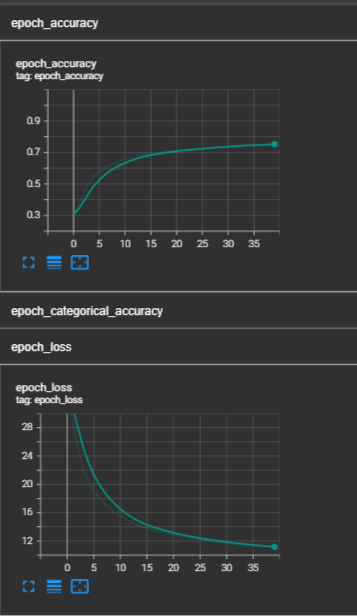

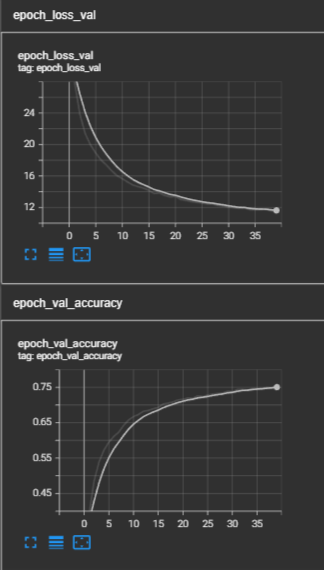

จากผลลัพธ์ที่ได้จาก tensorboard พบว่าค่า loss ที่ 40 epoches มีลักษณะเข้าใกล้ค่าคงที่เเล้ว เเละกราฟ loss ของ train กับ validate มีความคล้ายคลึงกัน คือลดลงเเละไม่เพิ่มขึ้น แสดงว่า model นี้เป็น Good Fitting (Ref. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

### **Trainable True**

In [37]:
def PosTagwithCRFPretainweight_tanh_trainable(name='POSTaggerwithCRFPretainweight_tanh_trainable',embedding_matrix=None):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    if embedding_matrix is not None:
        output = (Embedding(num_words,
                            embedding_dim,
                            input_length=102,
                            mask_zero=True,
                            weights=[embedding_matrix],
                            trainable=True,
                            name='EmbeddingLayer'))(inputs)
    else:
        output = (Embedding(len(word_to_idx),embedding_dim,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    
    output = TimeDistributed(Dense(n_classes,activation='tanh'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()

    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model.build(input_shape=(None,102))
    model._name = name
    return model

In [38]:
K.clear_session()

model_POS_CRF_Pretainweight_tanh_trainable = PosTagwithCRFPretainweight_tanh_trainable(name='CRFP_T',embedding_matrix=embedding_matrix)
config = POSConfig()
config.epochs = 40 

his_pos_crf_pre =  model_train(x_train,y_train_pad,model_POS_CRF_Pretainweight_tanh_trainable,config,retrain=False)

Model: "CRFP_T"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480672    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),             4656 

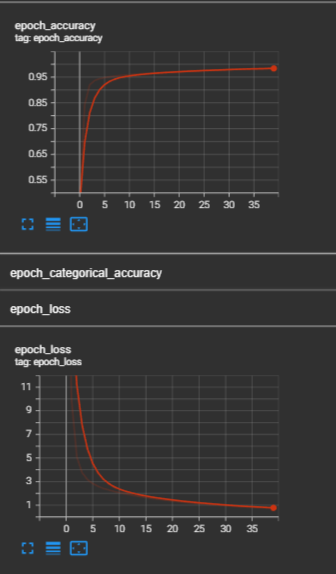

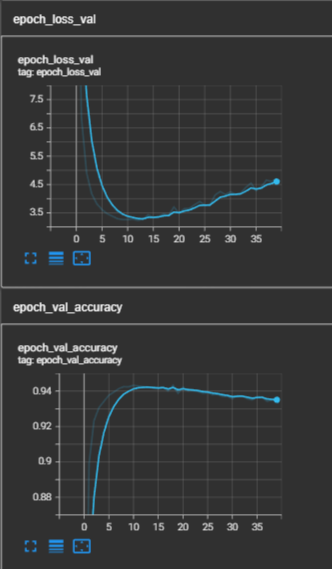

จากกราฟจะเห็นว่าเมื่อ epoch > 10 จะทำให้กราฟ loss ของ train มีค่าต่างกับ validate อย่างมาก ซึ่งเป็นการ overfitting ทำให้ model ไม่สามารถทำนายค่าให้ถูกต้องได้

In [39]:
K.clear_session()

model_POS_CRF_Pretainweight_tanh_trainable = PosTagwithCRFPretainweight_tanh_trainable(name='CRFP_T_10',embedding_matrix=embedding_matrix)
config = POSConfig()
config.epochs = 10 

his_pos_crf_pre =  model_train(x_train,y_train_pad,model_POS_CRF_Pretainweight_tanh_trainable,config,retrain=False)

Model: "CRFP_T_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480672    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),             46

### **Load Model**

In [40]:
model_POS_CRF_Pretainweight = load_model("tf_logs/POS/POSTaggerwithCRFPretainweight_tanh/POSTaggerwithCRFPretainweight_tanh")

In [41]:
model_POS_CRF_Pretainweight_train = load_model("tf_logs/POS/CRFP_T_10/CRFP_T_10")

### **Model Prediction**

In [42]:
his_pos_crf_pre_pred = get_y_pred(model_POS_CRF_Pretainweight,x_test)
df_his_pos_crf_pre = evaluation_report(y_test, his_pos_crf_pre_pred)

145/145 [==============================] - 19s 126ms/step


,tag,precision,recall,f_score,correct_count
0,1,98.602526,99.565807,99.081826,3669
1,2,81.498987,73.169253,77.109819,6035
2,3,64.060879,76.760021,69.837849,12964
3,4,71.362113,80.722798,75.754385,10431
4,5,100.0,83.58209,91.056911,56
5,6,79.829545,53.831418,64.302059,281
6,7,97.361872,94.083694,95.694716,1956
7,8,48.502994,19.518072,27.835052,81
8,9,48.58156,37.228261,42.153846,137
9,10,29.310345,8.104887,12.698413,68


In [43]:
his_pos_crf_pre_train_pred = get_y_pred(model_POS_CRF_Pretainweight_train,x_test)
df_his_pos_crf_pre_train = evaluation_report(y_test, his_pos_crf_pre_train_pred)

145/145 [==============================] - 19s 124ms/step


,tag,precision,recall,f_score,correct_count
0,1,99.891127,99.592944,99.741813,3670
1,2,94.848851,95.101843,94.975179,7844
2,3,91.521239,96.571733,93.97868,16310
3,4,99.92239,99.636279,99.77913,12875
4,5,95.652174,98.507463,97.058824,66
5,6,99.782135,87.739464,93.374108,458
6,7,97.35195,97.258297,97.305101,2022
7,8,67.696629,58.072289,62.516213,241
8,9,75.076923,66.304348,70.41847,244
9,10,65.261383,46.126341,54.050279,387


### **TODO 3**
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b>

In [44]:
# Map tage to tag name
tagname = label_to_idx.keys()
temp = []
for key in tagname:
    dicttemp = {}
    dicttemp[key] = label_to_idx[key]
    temp.append(dicttemp)
# Reverse the dictionary
tagname = {v: k for d in temp for k, v in d.items()}
print(tagname)
df_npos['tag_name'] = df_npos['tag'].map(tagname)
df_npos = df_npos[['tag','tag_name', 'precision', 'recall', 'f_score', 'correct_count']]

{1: 'FIXN', 2: 'VACT', 3: 'NCMN', 4: 'PUNC', 5: 'CFQC', 6: 'DONM', 7: 'JCRG', 8: 'NCNM', 9: 'CNIT', 10: 'NPRP', 11: 'NTTL', 12: 'XVAM', 13: 'VSTA', 14: 'RPRE', 15: 'ADVN', 16: 'JSBR', 17: 'DDAC', 18: 'XVBM', 19: 'XVMM', 20: 'DIBQ', 21: 'PREL', 22: 'VATT', 23: 'XVAE', 24: 'DCNM', 25: 'CMTR', 26: 'FIXV', 27: 'PPRS', 28: 'XVBB', 29: 'DIAC', 30: 'PDMN', 31: 'DDAN', 32: 'CLTV', 33: 'ADVP', 34: 'NLBL', 35: 'ADVI', 36: 'CMTR@PUNC', 37: 'JCMP', 38: 'ADVS', 39: 'DDBQ', 40: 'NEG', 41: 'PNTR', 42: 'EITT', 43: 'DDAQ', 44: 'NONM', 45: 'EAFF', 46: 'DIAQ', 47: 'CVBL'}


In [45]:
df_his_pos_crf = df_his_pos_crf.drop(['tag'],axis=1)
df_his_pos_crf_pre = df_his_pos_crf_pre.drop(['tag'],axis=1)
df_his_pos_crf_pre_train = df_his_pos_crf_pre_train.drop(['tag'],axis=1)

In [46]:
df_mixed = pd.concat([df_npos,df_his_pos_crf,df_his_pos_crf_pre_train], axis=1)
df_mixed

,tag,tag_name,precision,recall,f_score,correct_count,precision,recall,f_score,correct_count,precision,recall,f_score,correct_count
0,1,FIXN,99.891127,99.592944,99.741813,3670,99.863946,99.592944,99.728261,3670,99.891127,99.592944,99.741813,3670
1,2,VACT,93.411821,95.235209,94.314703,7855,93.585311,95.162464,94.367298,7849,94.848851,95.101843,94.975179,7844
2,3,NCMN,91.337421,95.26911,93.261846,16090,91.043854,96.003316,93.457836,16214,91.521239,96.571733,93.97868,16310
3,4,PUNC,99.984464,99.605324,99.794534,12871,99.860314,99.582108,99.721017,12868,99.92239,99.636279,99.77913,12875
4,5,CFQC,88.0,98.507463,92.957746,66,95.652174,98.507463,97.058824,66,95.652174,98.507463,97.058824,66
5,6,DONM,99.781659,87.547893,93.265306,457,99.56427,87.547893,93.170234,457,99.782135,87.739464,93.374108,458
6,7,JCRG,97.722868,97.017797,97.369056,2017,97.267498,97.594998,97.430972,2029,97.35195,97.258297,97.305101,2022
7,8,NCNM,59.852217,58.554217,59.196102,243,62.133333,56.144578,58.987342,233,67.696629,58.072289,62.516213,241
8,9,CNIT,76.510067,61.956522,68.468468,228,74.832215,60.597826,66.966967,223,75.076923,66.304348,70.41847,244
9,10,NPRP,61.862917,41.954708,50.0,352,61.929825,42.073897,50.106458,353,65.261383,46.126341,54.050279,387


โดยผลลัพท์จากการเปรียบเทียบทั้ง 3 โมเดลจะสั่งเกตได้ว่า

ผลลัพธ์ของโมเดลแต่ละ model สามารถเรียงลำดับได้ดังนี้

1. โมเดล Neural POS Tagger with CRF pre-trainaed weight (accuracy = 93.57)
2. โมเดล Neural POS Tagger with CRF (accuracy = 93.10)
3. โมเดล Neural POS Tagger (accuracy = 92.97)
4. โมเดล Neural POS Tagger with CRF pre-trainaed weight not train embedding layer (accuracy = 75.30)

โดยเหตุผลที่ทำให้เกิดผลลัพธ์นี้เกิดขึ้นจะสามารถแบ่งเป็น 3 ส่วนได้ดังนี้

1. Performance ของโมเดลที่ใช้ CRF with pre-trainaed weight not train embedding layer ทำไมถึงแย่กว่าโมเดลแื่น ๆ อย่างเห็นได้ชัด

    โมเดล POS with CRF pre-trainaed weight มีค่า accuracy ที่ต่ำกว่าโมเดลอื่น ๆ อย่างเห็นได้ชัด ทั้งนี้เหตุผลจะเกี่ยวข้องกับการทำ embedding matirx ของคำศัพท์ที่ไม่มีใน corpus ที่ใช้ในการ train โมเดลทำให้โมเดลที่ใช้ embedding ไม่สามารถทำนายคำที่ไม่มีใน corpus ได้ดี และจะทำให้มีค่า accuracy ต่ำกว่าโมเดลอื่น ๆ อีก (จากผลลัทธ์ในการรัน rom dict embeddings_basic_ff, found embeddings for 5158 words (34.34%) and 9861 (65.65%) not found.)

2. Performance ของ model ที่ใช้ CRF ดีกว่าโทเดลที่ไม่ได้ใช้ CRF

    การใช้  Neural network (NN) ร่วมกับ Conditional Random Fields (CRF) ใน POS Tagging จะให้ผลลัพธ์ที่ดีกว่า หากเทียบกับการใช้โมเดลใดโมเดลหนึ่งเพียงโมเดลเดียว โดยสามารถให้เหตุผล คือ โมเดล Neural network สามารถเรียนรู้รูปแบบและคุณลักษณะที่ซับซ้อนจากข้อมูลได้ ในขณะเดียวกัน CRF สามารถจับความสัมพันธ์ระหว่าง Labels ที่ติดกันได้ การใช้ CRF จะช่วยให้เราสามารถดึง คุณลักษณะ(feature) เพิ่มเติมได้ เช่น คุณลักษณะที่เกี่ยวข้องกับประโยค คุณลักษณะที่เชื่อมโยงกันระหว่างคำที่อยู่ใกล้เคียงกัน และคุณลักษณะที่ซับซ้อนอื่น ๆ ที่ไม่สามารถเรียนรู้ได้ด้วย Neural networks เพียงอย่างเดียว อีกทั้ง CRF สามารถให้ผลลัพธ์ที่อธิบายเข้าใจได้ดีกว่า ซึ่งมีประโยชน์ในงานที่ต้องการความชัดเจนในผลลัพธ์ เช่น การแก้ไขความผิดพลาดของโมเดลให้ลดลง ดังนั้นการใช้ Neural networks ร่วมกับ CRF เป็นวิธีการที่มีประสิทธิภาพและมีความยืดหยุ่นสูงในการทำ POS tagging โดยสามารถจัดการกับความซับซ้อนและความกำกวมในภาษาธรรมชาติได้มีประสิทธิภาพมากขึ้น ส่งผลให้โมเดลมีความเเม่นยำเเละประสิทธิภาพที่ดีขึ้น

3. Performance ของโมเดลที่ใช้ CRF with pre-trainaed weight ถึงดีกว่า โมเดล Neural POS Tagger with CRF ธรรมดา

    การที่โมเดลที่ใช้ pre-trainaed weight ได้ผลลัพท์ดีกว่าเนื่องจาก การใช้ pre-trainaed weight จะช่วยให้โมเดลสามารถเรียนรู้ความคำได้ง่ายมากขึ้นไม่ต้องเริ่มจากการเรียนรู้ความคำใหม่ทั้งหมดทำให้มีประสิทธิภาพที่ดีขึ้น

โดย Tag ที่พบเห็น

- NCNM : NUM (Cardinal number)
- NPRP : PROPN (Proper noun)
- CLTV : NOUN (Collective classifier)
- ADVP : ADV (Adverb with prefixed form)
- ADVI : ADV (Adverb with iterative form)
- ADVS : ADV (Sentential adverb)
- DDAN : DET (Definite determiner)

## Get Wrong Prediction Function

To get wrong word prediction from y_pred.

In [47]:
# get wrong prediction

def get_wrong_pred(x_true,y_true,y_pred,y_pred1,y_pred2):
    
    # remove padding
    x_true_new = []
    for i in range(len(x_true)):
        data = x_true[i]
        temp = []
        for j in range(len(data)):
            if data[j] != 0:
                temp.append(data[j])
        x_true_new.append(temp)
                
    wrong_pred = []
    for i in range(len(y_true)):
        tempdict = {}
        if not np.array_equal(y_true[i],y_pred[i]) or not np.array_equal(y_true[i],y_pred1[i]) or not np.array_equal(y_true[i],y_pred2[i]):
            tempdict['index'] = i
            tempdict['sentence'] = x_true_new[i]
            tempdict['true'] = y_true[i]
            tempdict['npos'] = y_pred[i]
            tempdict['crf'] = y_pred1[i]
            wrong_pred.append(tempdict)
    return wrong_pred

def idx_to_word(idx):
    for word, index in word_to_idx.items(): 
        if index == idx: 
            return word
    return None

def idx_to_label(idx):
    for label, index in label_to_idx.items(): 
        if index == idx:
            return label
    return None

def decode_wrong_pred(wrong_pred):
    temp = []
    for i in range(len(wrong_pred)):
        tempdict = {}
        tempdict['index'] = wrong_pred[i]['index']
        tempdict['sentence'] = [idx_to_word(idx) for idx in wrong_pred[i]['sentence']]
        tempdict['true'] = [idx_to_label(idx) for idx in wrong_pred[i]['true']]
        tempdict['npos'] = [idx_to_label(idx) for idx in wrong_pred[i]['npos']]
        tempdict['crf'] = [idx_to_label(idx) for idx in wrong_pred[i]['crf']]
        temp.append(tempdict)
    return temp

def random_print_sample(wrong_pred, random_unit=10):
    for i in range(random_unit):
        random_index = np.random.randint(0,len(wrong_pred))
        temp_sentence = '/'.join(wrong_pred[random_index]['sentence'])
        temp_true = '/'.join(wrong_pred[random_index]['true'])
        temp_npos = '/'.join(wrong_pred[random_index]['npos'])
        temp_crf = '/'.join(wrong_pred[random_index]['crf'])
        print(f'sentence: {temp_sentence}')
        print(f'true    : {temp_true}')
        print(f'npos    : {temp_npos}')
        print(f'crf     : {temp_crf}')
        print('======================================================================')
        
def random_print_sample_with_tag(wrong_pred, random_unit=10,tag = None):
    if tag == None:
        random_print_sample(wrong_pred, random_unit)
    else:
        temp = []
        for i in range(len(wrong_pred)):
            if tag in wrong_pred[i]['npos'] or tag in wrong_pred[i]['crf']:
                temp.append(wrong_pred[i])
        random_print_sample(temp, random_unit)

In [48]:
wrong_pred = get_wrong_pred(x_test, y_test, ypred, his_pos_crf_pred, his_pos_crf_pre_pred)

In [49]:
output_wrong = decode_wrong_pred(wrong_pred)

In [50]:
random_print_sample_with_tag(output_wrong, random_unit=10,tag = 'DDAN')

sentence: ใน/การ/วิจัย/และ/พัฒนา/เครื่องควบคุม/ดังกล่าว/<space>/จะ/ต้อง/พัฒนา/ใน/ส่วน/ของ/โปรแกรม/<space>/User Interface/<comma>/<space>/DATABAS 2/<comma>/<space>/DATABAS 2/<space>/<left_parenthesis>/input/<right_parenthesis>
true    : RPRE/FIXN/VACT/JCRG/VACT/NCMN/DDAC/PUNC/XVBM/XVMM/VACT/RPRE/NCMN/RPRE/NCMN/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC
npos    : RPRE/FIXN/VACT/JCRG/VACT/NCMN/DDAN/PUNC/XVBM/XVMM/VACT/RPRE/NCMN/RPRE/NCMN/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC
crf     : RPRE/FIXN/VACT/JCRG/VACT/NCMN/DDAN/PUNC/XVBM/XVMM/VACT/RPRE/NCMN/RPRE/NCMN/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC
sentence: วิธี/การ/เก็บ/ข้อมูล/ดังกล่าว/<space>/อาจ/ใช้/การ/ฉาย/รังสีเอ็กซ์/ซึ่ง/มี/การ/กระจาย/แบบ/กรวย/<space>/DATABAS 2/<space>/ผ่าน/วัตถุ
true    : NCMN/FIXN/VACT/NCMN/DDAC/PUNC/XVMM/VACT/FIXN/VACT/NCMN/PREL/VSTA/FIXN/VACT/NCMN/NCMN/PUNC/NCMN/PUNC/VSTA/NCMN
npos    : NCMN/FIXN/VACT/NCMN/DDAN/PUNC/XVMM/VACT/FIXN/VACT/NCMN/PREL/VSTA/FIX

เราได้ทำการทดลองนำ Tag ที่เเต่ละโมเดลทำนายผิดพลาดมาดู ว่ามีความเเตกต่างกันอย่างไร เเละสามารถบอกอะไรได้บ้าง โดยได้ผลลัพธ์ดังนี้
1. npos มีการทำนายที่ผิดพลาดในบาง Tag เช่น DCNM, ADVN, DONM, CNIT, CMTR, NPRP, VATT ทายเป็น NCNM
2. crf มีการทำนายที่ผิดพลาดในบาง Tag เช่น NPRP, DCNM, CMTR, VATT, CNIT ทายเป็น NCNM
3. npos มีการทำนายที่ผิดพลาดในบาง Tag เช่น EITT, ADVN, JSBR ทายเป็น ADVP
4. crf มีการทำนายที่ผิดพลาดในบาง Tag เช่น ADVN ทายเป็น ADVP
5. npos มีการทำนายที่ผิดพลาดในบาง Tag เช่น DDAC ทายเป็น DDAN
6. crf มีการทำนายที่ผิดพลาดในบาง Tag เช่น DDAC ทายเป็น DDAN (ทำนาย DDAC ผิดน้อยกว่า npos)
- จากข้อมูลที่ได้พบว่า crf มีจำนวน Tag ที่ทำนายผิดพลาดน้อยกว่า npos (npos มี Tag ที่ทำนายผิดเป็น NCNM ประมาณ 7 Tag ส่วน crf ประมาณ 5 Tag) ทำให้เป็นตัวยืนยันว่าค่า Accuracy ที่ได้จากการ Train model เป็นค่าที่ถูกต้อง
- ในการทำนายผิดของโมเดล มีความสมเหตุสมผล เช่น ทำนาย DCNM (Determiner, cardinal number expression) เป็น NCNM (Cardinal number) เพราะทั้งสอง Tag นี้มีความใกล้เคียงกันมาก DCNM เช่น หนึ่งคน, เสือ 2 ตัว / NCNM เช่น หนึ่ง, สอง, สาม, 1, 2, 10 สังเกตได้ว่าทั้งคู่มีตัวเลขเเละตัวอักษรเเทนตัวเลขที่คล้ายกัน หรือ การทำนาย DDAC (Definite determiner, allowing classifier
in between) เป็น DDAN (Definite determiner, after noun without
classifier in between) เพราะทั้งสอง Tag นี้มีความใกล้เคียงกันมาก DDAN เช่น ยี่, นั่น, โน่น, ทั้งหมด / DDAC เช่น นี้, นั้น, โน้น, นู้น ดังนั้นเหตุผลเหล่านี้อาจจะทำให้โมเดลทำนายผิดพลาดได้ (Ref.https://pythainlp.github.io/dev-docs/api/tag.html)